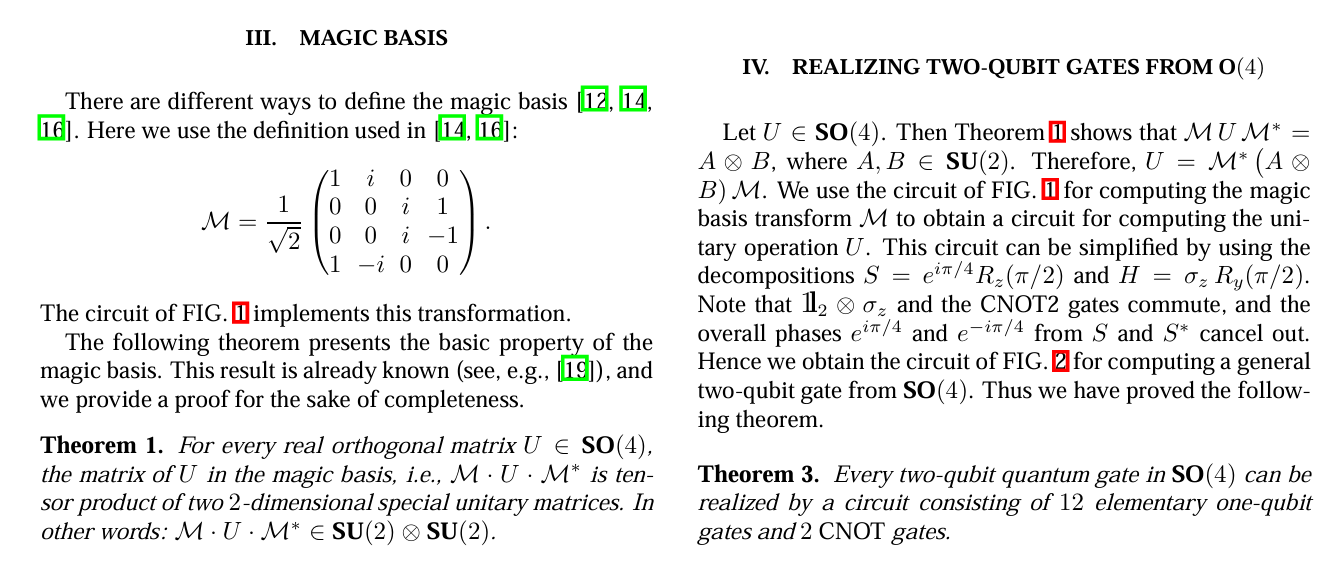

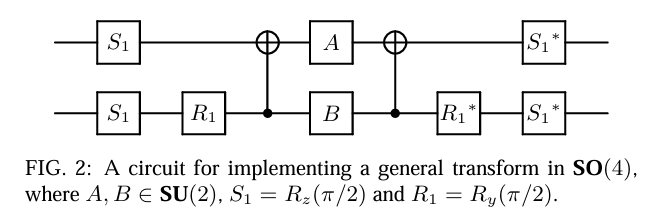

In [150]:
#from qibo.models.variational import VQE
# from boostvqe.ansatze import build_circuit
from qibo import hamiltonians, Circuit,gates
#from pathlib import Path
import numpy as np
#import scipy

In [151]:
t = 0.01
steps = 1
delta=0.5
nqubits=2


In [152]:
from qutip import tensor,sigmaz,sigmax, sigmay, Qobj
def _SO4_single_qubit_unitary(delta,t):
    """
    Constructs single-qubit unitaries from the decomposition of 
    a two-qubit unitary operation in SO(4).

    Args:
    delta (float): Coefficient for the Z component.

    Returns:
    tuple: A tuple containing two single-qubit unitary matrices (A, B).
    """

    # Calculate the XXZ unitary in magic basis
    from qutip import tensor, sigmax, sigmay, sigmaz, Qobj
    M = np.array(
        [[1, 1j, 0, 0], [0, 0, 1j, 1], [0, 0, 1j, -1], [1, -1j, 0, 0]]
    )/ np.sqrt(2)
    M_dag = np.asarray(np.asmatrix(M).H)
    H = tensor(sigmax(),sigmax()) + tensor(sigmay(),sigmay()) + delta*tensor(sigmaz(),sigmaz())
    import scipy
    U = 1j* scipy.linalg.expm( -1j * t * H)
    magic_U = M * U * M_dag

    # Partial trace to get single-qubit unitary matrices A and B
    A = np.asarray(Qobj(magic_U.reshape((4,4)), dims=[[2,2],[2,2]]).ptrace(0))
    B = np.asarray(Qobj(magic_U.reshape((4,4)), dims=[[2,2],[2,2]]).ptrace(1))
    
    return A, B

In [153]:
def _add_gates_SO4(circuit,list_q_i,list_q_ip1, A, B):
    circuit.add(gates.RZ(q_i, np.pi/2) for q_i in list_q_i)
    circuit.add(gates.RZ(q_ip1, np.pi/2) for q_ip1 in list_q_ip1)
    circuit.add(gates.RY(q_ip1, np.pi/2) for q_ip1 in list_q_ip1)
    circuit.add(gates.CNOT(q_ip1, q_i) for q_i,q_ip1 in zip(list_q_i,list_q_ip1))

    circuit.add(gates.Unitary(A,q_i) for q_i in list_q_i)
    circuit.add(gates.Unitary(B,q_ip1) for q_ip1 in list_q_ip1)
    
    circuit.add(gates.CNOT(q_i, q_ip1) for q_i,q_ip1 in zip(list_q_i,list_q_ip1))
    circuit.add(gates.RY(q_ip1, -np.pi/2) for q_ip1 in list_q_ip1)
    circuit.add(gates.RZ(q_i, -np.pi/2) for q_i in list_q_i)
    circuit.add(gates.RZ(q_ip1, -np.pi/2) for q_ip1 in list_q_ip1)
    return circuit

In [154]:
def nqubit_XXZ_SO4_decomposition(nqubits,t,delta,steps):
    circuit = Circuit(nqubits = nqubits)

    even_numbers = [num for num in range(nqubits) if num % 2 == 0]
    odd_numbers = [num for num in range(nqubits) if num % 2 == 1]

    A,B = _SO4_single_qubit_unitary(delta,t)  

    if nqubits%2 == 0:
        even_numbers_end_0 = [num for num in range(1,nqubits) if num % 2 == 0]
        even_numbers_end_0.append(0)
        
        circuit = _add_gates_SO4(circuit,even_numbers,odd_numbers,A,B)
        circuit = _add_gates_SO4(circuit,odd_numbers,even_numbers_end_0,A,B)

    elif nqubits%2 == 1:
        circuit = _add_gates_SO4(circuit,even_numbers[:-1],odd_numbers,A,B)
        circuit = _add_gates_SO4(circuit,odd_numbers,even_numbers[1:],A,B)
        circuit = _add_gates_SO4(circuit,[nqubits-1],[0],A,B)

    multi_layer = Circuit(nqubits = nqubits)
    for step in range(steps):
        multi_layer += circuit
    return multi_layer


In [155]:
h_xxz = hamiltonians.XXZ(nqubits=nqubits, delta = delta)
u = h_xxz.exp(t)
circ = nqubit_XXZ_SO4_decomposition(nqubits=nqubits,t=t,delta=delta,steps=steps)
v = circ.unitary()
print(np.linalg.norm(u+v))
print(circ.draw())

2.1359066055018783
q0: ─RZ────X─U─o─RZ─RZ─RY─o─U─X─RY─RZ─
q1: ─RZ─RY─o─U─X─RY─RZ─RZ─X─U─o─RZ────


In [156]:
U = tensor(sigmax(),sigmax()) + tensor(sigmay(),sigmay()) + delta*tensor(sigmaz(),sigmaz())

# Calculate the XXZ unitary in magic basis
from qutip import tensor, sigmax, sigmay, sigmaz, Qobj, identity
M = np.array(
    [[1, 1j, 0, 0], [0, 0, 1j, 1], [0, 0, 1j, -1], [1, -1j, 0, 0]]
)/ np.sqrt(2)
M_dag = np.asarray(np.asmatrix(M).H)
U = tensor(sigmax(),sigmax()) + tensor(sigmay(),sigmay()) + delta*tensor(sigmaz(),sigmaz())
magic_U = M * U * M_dag

# Partial trace to get single-qubit unitary matrices A and B
A = np.asarray(Qobj(magic_U.reshape((4,4)), dims=[[2,2],[2,2]]).ptrace(0))
B = np.asarray(Qobj(magic_U.reshape((4,4)), dims=[[2,2],[2,2]]).ptrace(1))



In [157]:
np.linalg.norm(np.kron(A,B) - magic_U)

1.7320508075688767

In [158]:
circuit = Circuit(2)
q_i = 0
q_ip1 = 1
circuit.add(gates.RZ(q_i, np.pi/2) )
circuit.add(gates.RZ(q_ip1, np.pi/2))
circuit.add(gates.RY(q_ip1, np.pi/2) )
circuit.add(gates.CNOT(q_ip1, q_i))

circuit.add(gates.Unitary(A,q_i))
circuit.add(gates.Unitary(B,q_ip1))

circuit.add(gates.CNOT(q_i, q_ip1))
circuit.add(gates.RY(q_ip1, -np.pi/2))
circuit.add(gates.RZ(q_i, -np.pi/2) )
circuit.add(gates.RZ(q_ip1, -np.pi/2) )

print(np.linalg.norm(np.asarray(U)-circuit.unitary()))

3.0413812651491097


In [159]:
import numpy as np

from qibo import gates, matrices
from qibo.backends import NumpyBackend, _check_backend
from qibo.config import raise_error

def schmidt_decompose_matrix(state, backend=None): 
    """Decomposes a two-qubit tensor product unitary to its single-qubit parts. 

    Args: 
        state (ndarray): product state to be decomposed. 

    Returns: 
        (ndarray, ndarray): decomposition 

    """ 
    backend = _check_backend(backend) 
    if backend.__class__.__name__ == "TensorflowBackend": 
        u, d, v = np.linalg.svd(backend.np.reshape(state, (4, 4))) 
    else: 
        u, d, v = backend.np.linalg.svd(backend.np.reshape(state, (4, 4)))
    print(d) 
   
    
    return u, d, v

In [160]:
identity(4)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [161]:
#test_u = np.asarray(tensor(identity(2),sigmax()))
test_u = M
u,d,v = schmidt_decompose_matrix(test_u)
np.linalg.norm(u*d@v-test_u)

[1. 1. 1. 1.]


2.9893669801409083e-16

In [162]:
u_p = Qobj(u.reshape((4,4)), dims=[[2,2],[2,2]]).ptrace(0)
print(np.round(u,2))
print(np.round(u_p))

[[-0.71+0.j    0.  +0.j    0.  -0.71j  0.  +0.j  ]
 [ 0.  +0.j    0.  -0.71j  0.  +0.j   -0.  +0.71j]
 [ 0.  +0.j    0.  -0.71j  0.  +0.j   -0.  -0.71j]
 [-0.71+0.j    0.  +0.j    0.  +0.71j  0.  +0.j  ]]
[[-1.-1.j -0.+0.j]
 [ 0.+0.j  0.+0.j]]


In [163]:
v_p = Qobj(v.reshape((4,4)), dims=[[2,2],[2,2]]).ptrace(1)
print(np.round(v,2))
print(np.round(v_p))

[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j -1.+0.j -0.+0.j]
 [-0.+0.j -1.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j  0.-1.j]]
[[-1.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j]]


In [164]:
np.linalg.norm(np.kron(u_p,v_p) - test_u)

2.2360679774997894